CONTEXT

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.(https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)



In this project, an exploration of the data will be carried out, a question associated with diabetes and the data available will be posed and answered, finally 5 models will be built using supervised learning techniques to classify the presence or not of the disease given the attributes used. The models to be used will be: Logistic regression, K nearest neighbors, support vector machine and two different architectures of artificial neural network with a different type of training.

In [1]:
#Necessary libraries

import torch # Estructuras de datos para tensores multidimensionales
import torch.nn.functional as F # Contains the functions of the torch.nn library
from torch import nn #Basic building blocks for graphs

#plot libs
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

#sklearn libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

#pandas libs
import pandas as pd

#numpy libs
import numpy as np


In [2]:
matplotlib.__version__

'3.5.1'

Data exploration


In [3]:
data=pd.read_excel(r"C:\Users\PERSONAL\Desktop\Deep learning\Diabetes\Diabetesdataset.xlsx") #Data to pandas frame from excel

In [4]:
#Data dimension and description
print(data.shape)
print(data.describe())

(768, 9)
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean   289.796875                431.856771   33.240885    0.348958  
std    116.757554                336.256774   11.760232    0.476951  
min      0.000000         

In [5]:
#Na values
print(data.isna().sum());

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


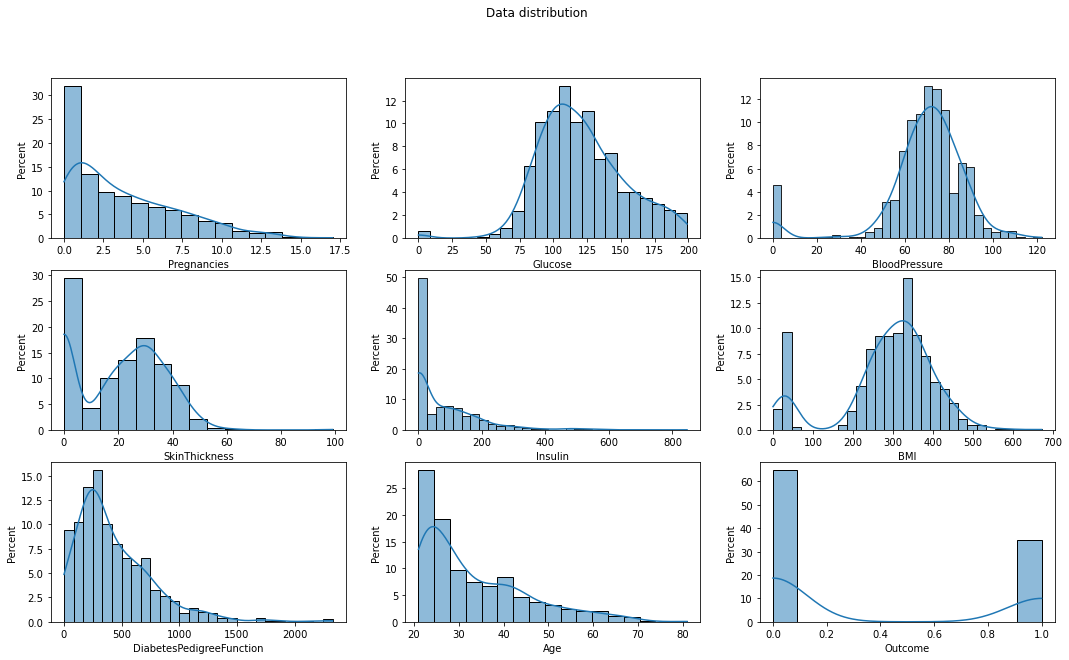

In [6]:
#Data distribution by percentage
rows,columns= 3,3;
data_index=-1;
Index=data.columns
figure,axes= plt.subplots(3, 3, sharex=False,figsize=(18, 10))
figure.suptitle("Data distribution")
for i in range(0,rows):
    for j in range(0,columns):
        data_index+=1;
        sns.histplot(ax=axes[i,j],data=data[Index[data_index]],stat ='percent',kde=True);

Even if theres isnt Na values, there is zero values in BloodPressure,Insulin,SkinThickness,BMI and Glucose. These values cant be zero even in a rare conditions, due this and to avoid eliminate information we will sustitute this values by the feature mean.(This is not the optimal case but for practical purposes it will be)

In [7]:
#Count of zero values in selected features
print(data["BloodPressure"].loc[data["BloodPressure"]==0].count());
print(data["Insulin"].loc[data["Insulin"]==0].count());
print(data["Glucose"].loc[data["Glucose"]==0].count());
print(data["SkinThickness"].loc[data["SkinThickness"]==0].count());
print(data["BMI"].loc[data["BMI"]==0].count());

35
374
5
227
11


In [8]:
#Sustitute of zero values by the mean of column
for column in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]:
    data[column] = data[column].replace(0, np.NaN)
    mean = int(data[column].mean(skipna = True))
    data[column] = data[column].replace(np.NaN, mean)

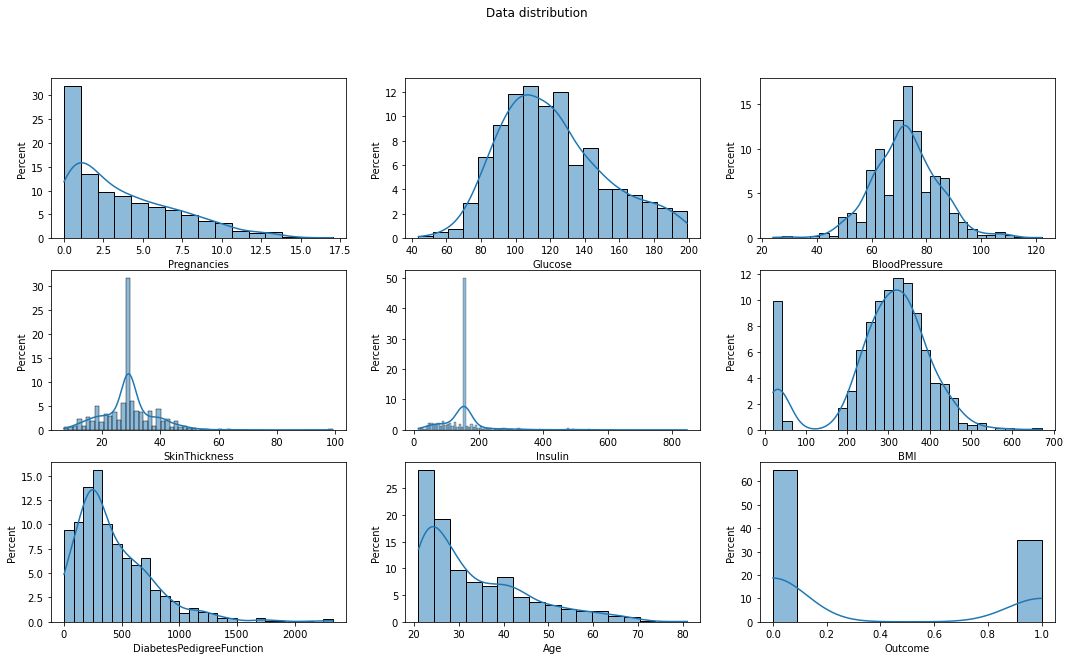

In [9]:
#Data distribution by percentage
rows,columns= 3,3;
data_index=-1;
Index=data.columns
figure,axes= plt.subplots(3, 3, sharex=False,figsize=(18, 10))
figure.suptitle("Data distribution")
for i in range(0,rows):
    for j in range(0,columns):
        data_index+=1;
        sns.histplot(ax=axes[i,j],data=data[Index[data_index]],stat ='percent',kde=True);

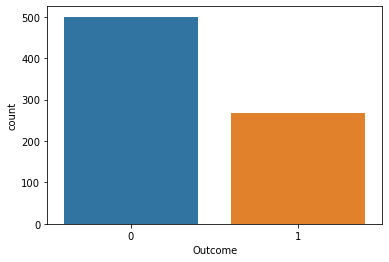

In [10]:
#Labels distribution
(sns.countplot(x='Outcome',data=data));

As the two classes are unbalanced and in addition to the fact that the problem is associated with health, as performance metrics, the recall and specificity will be evaluated primarily.

QUESTION:
Do people with diabetes have higher blood pressure than those without?

Diastolic pressure over 85 mm Hg is considered high ( https://fmdiabetes.org/hipertension-y-diabetes/ )

In [11]:
#Extraction of bloodPressure in people with diabetes
data_copy=data.copy();
dataBP_Out=data_copy[['BloodPressure','Outcome']];
dataBP_Out=dataBP_Out.drop(dataBP_Out[dataBP_Out['Outcome']==0].index)

In [12]:
dataBP_Out

,BloodPressure,Outcome
0,72.0,1
2,64.0,1
4,40.0,1
6,50.0,1
8,70.0,1
...,...,...
755,88.0,1
757,72.0,1
759,92.0,1
761,74.0,1


In [13]:
print('Number of people with diabetes: '+str(dataBP_Out.shape[0]))
print('number of people with diabetes and high blood pressure: '+str(dataBP_Out['BloodPressure'].loc[dataBP_Out['BloodPressure']>85].count()))
print('number of people with diabetes and not high blood pressure: '+str(dataBP_Out['BloodPressure'].loc[dataBP_Out['BloodPressure']<=85].count()))

Number of people with diabetes: 268
number of people with diabetes and high blood pressure: 49
number of people with diabetes and not high blood pressure: 219


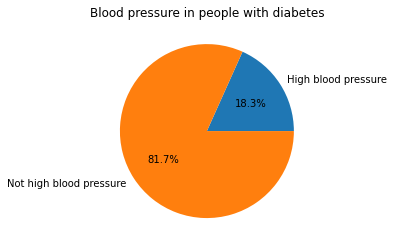

In [14]:
#Pie chart for visualization
info=[(dataBP_Out['BloodPressure'].loc[dataBP_Out['BloodPressure']>85].count())/dataBP_Out.shape[0],(dataBP_Out['BloodPressure'].loc[dataBP_Out['BloodPressure']<=85].count()/dataBP_Out.shape[0])];
labels=['High blood pressure','Not high blood pressure']
plt.pie(info,labels=labels,autopct='%0.1f%%');
plt.title("Blood pressure in people with diabetes");
plt.show()

Although according to various sources, people with diabetes tend to have higher blood pressure, in this case the data do not behave in this way, so according to the above, a relationship between diabetes and hypertension cannot be concluded.

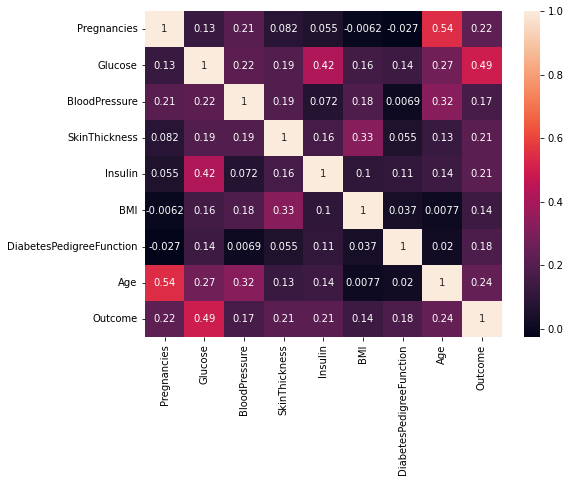

In [15]:
#Pearson correlation matrix
corr_df = data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

The highest correlation between the output label and the data attributes is in the case of blood glucose, however this is still not significant, so a linear dependence between glucose and diabetes cannot be established for this set. of data or for any other characteristic.

DATA NORMALIZATION

Data normalization allows a common scale to be used without distorting the difference between intervals or losing information. It is necessary for supervised learning algorithms to function optimally.

In [16]:
Inputs=data.drop(columns='Outcome')
Labels=data['Outcome']

In [17]:
Inputs_norm=Inputs/Inputs.max() #Normalizing by dividing by the maximum value of each attribute

In [18]:
Procces_dataset=pd.concat([Inputs_norm,Labels],axis=1) # Join inputs_norm and Labels columns in one dataframe
Procces_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.611469,0.593334,0.294021,0.183548,0.438164,0.185426,0.410381,0.348958
std,0.198210,0.152945,0.099153,0.088800,0.100498,0.166024,0.144378,0.145188,0.476951
min,0.000000,0.221106,0.196721,0.070707,0.016548,0.029806,0.000429,0.259259,0.000000
25%,0.058824,0.501256,0.524590,0.252525,0.143617,0.378539,0.088021,0.296296,0.000000
50%,0.176471,0.587940,0.590164,0.292929,0.183215,0.460507,0.144697,0.358025,0.000000
75%,0.352941,0.704774,0.655738,0.323232,0.183215,0.535022,0.253972,0.506173,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Data split for models

In [19]:
#Extraction of values
X=Inputs_norm.values;
Y=Labels.values;
print(type(X),X.shape)
print(type(Y),Y.shape)

<class 'numpy.ndarray'> (768, 8)
<class 'numpy.ndarray'> (768,)


In [20]:
#Data split in train and test split,0.85% to train and 0.15% to test
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.15,random_state=10)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(652, 8) (116, 8)
(652,) (116,)


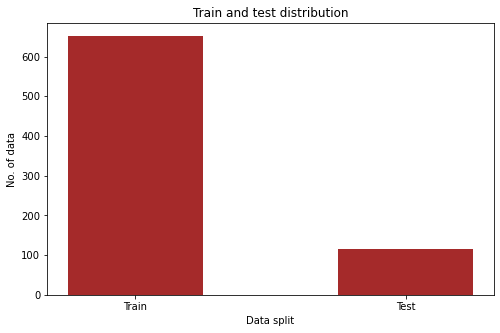

In [21]:
#Visualization
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(['Train','Test'], [y_train.shape[0],y_test.shape[0]], color ='brown',
        width = 0.5)
 
plt.xlabel("Data split")
plt.ylabel("No. of data")
plt.title("Train and test distribution")
plt.show()

MODELS FOR DIABETES PREDICTION

In [22]:
#Function to compute the specificity value (For recall in positive class we have scikit learn library)
def specificity(tn,fp):
    return round((tn/(fp+tn)),2)

In [23]:
#Dictionarys where results will be saved
Models=['LR','KNN','SVM','NN1','NN2'] #Five models we will try
cf_results={key: None for key in Models} #Confusion matrix results
metrics_results={key: [None,None] for key in Models} # Recall and specificity  value results for each model
print(cf_results)
print(metrics_results)

{'LR': None, 'KNN': None, 'SVM': None, 'NN1': None, 'NN2': None}
{'LR': [None, None], 'KNN': [None, None], 'SVM': [None, None], 'NN1': [None, None], 'NN2': [None, None]}


1.LOGISTIC REGRESSION

In [24]:
from sklearn.linear_model import LogisticRegression
Penalty=['l1','l2','none'] #List of penaltys to assess which is more accurate
for p in Penalty:
    LR= LogisticRegression(solver='saga',penalty=p) #Logistic regression model given solver and penalty
    LR.fit(x_train,y_train) #Fit the model from the training dataset
    print("Solver = "+p)
    print('Accuracy of logistic regression with penalty classifier on training set: {:.2f}'
        .format(LR.score(x_train, y_train)))
    print('Accuracy of logistic regression on test set: {:.2f}'
        .format(LR.score(x_test, y_test)))



Solver = l1
Accuracy of logistic regression with penalty classifier on training set: 0.77
Accuracy of logistic regression on test set: 0.74
Solver = l2
Accuracy of logistic regression with penalty classifier on training set: 0.78
Accuracy of logistic regression on test set: 0.75
Solver = none
Accuracy of logistic regression with penalty classifier on training set: 0.77
Accuracy of logistic regression on test set: 0.72


L1 and L2 regularization obtained equal and superior results to the model without regulation, therefore the model with L2 regularization will be chosen, although L1 could well have been chosen.

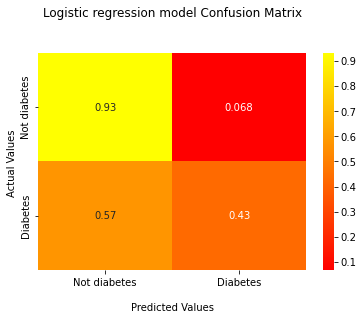

              precision    recall  f1-score   support

Not diabetes       0.74      0.93      0.83        74
    Diabetes       0.78      0.43      0.55        42

    accuracy                           0.75       116
   macro avg       0.76      0.68      0.69       116
weighted avg       0.76      0.75      0.73       116




In [25]:
from sklearn.metrics import recall_score
#Confusion matrix and classification report for logistic regression model
p='l2'
LR= LogisticRegression(solver='saga',penalty=p)
LR.fit(x_train,y_train) #Fit the model
y_pred= LR.predict(x_test) #Predict values for test data


cf_matrix = confusion_matrix(y_test, y_pred,normalize='true') #Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
metrics_results['LR']=[recall_score(y_test,y_pred),specificity(tn,fp)]; #Recall and specificity
cf_results['LR']=classification_report(y_test, y_pred, target_names=['Not diabetes','Diabetes']); #Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='autumn') #Confusion matrix heatmap

ax.set_title('Logistic regression model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not diabetes','Diabetes'])
ax.yaxis.set_ticklabels(['Not diabetes','Diabetes'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cf_results['LR'])
print()

2. K-NEAREST-NEIGHBOR

In [26]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors =[1,2,3,4,5,6];
for k in n_neighbors:
    knn = KNeighborsClassifier(k)
    knn.fit(x_train, y_train) #Fit the k-nearest neighbors classifier from the training dataset
    print("k="+str(k))
    print('Accuracy of K-NN classifier on training set: {:.2f}'
        .format(knn.score(x_train, y_train)))
    print('Accuracy of K-NN classifier on test set: {:.2f}'
        .format(knn.score(x_test, y_test)))

k=1
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.67
k=2
Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.69
k=3
Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.72
k=4
Accuracy of K-NN classifier on training set: 0.82
Accuracy of K-NN classifier on test set: 0.70
k=5
Accuracy of K-NN classifier on training set: 0.82
Accuracy of K-NN classifier on test set: 0.70
k=6
Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.71


The highest accuracy was obtained with K=1, being 1 which, despite being the highest value that can be obtained, this value is not recommended since it could indicate that the model is overfitted, therefore K will be selected equal to 3 who also obtains a good result in the training set and in the test set.

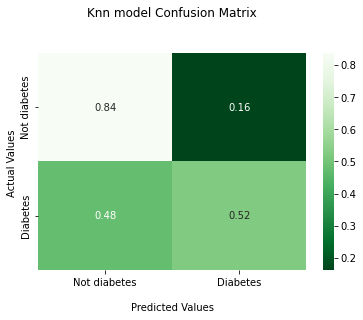

              precision    recall  f1-score   support

Not diabetes       0.76      0.84      0.79        74
    Diabetes       0.65      0.52      0.58        42

    accuracy                           0.72       116
   macro avg       0.70      0.68      0.69       116
weighted avg       0.72      0.72      0.72       116



In [27]:
#Confussion and classification report for knn model
k=3;#Number of neighhbors
knn = KNeighborsClassifier(k) #Knn classifier
knn.fit(x_train, y_train) #Fit the model
y_pred= knn.predict(x_test) #Predictt values for test data


cf_matrix = confusion_matrix(y_test, y_pred,normalize='true');#Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel(); #True negatives, false positives, false negativas and true positives
metrics_results['KNN']=[recall_score(y_test,y_pred),specificity(tn,fp)]; #Recall and specificity
cf_results['KNN']=classification_report(y_test, y_pred, target_names=['0','1']);#Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens_r') #Confusion matrix heatmap

ax.set_title('Knn model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not diabetes','Diabetes'])
ax.yaxis.set_ticklabels(['Not diabetes','Diabetes'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test, y_pred, target_names=['Not diabetes','Diabetes']))

3.SUPPORT VECTORIAL MACHINE (SVM)

Supervised learning algorithm to classify data by finding a separator between classes

In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score
#Trying different regularization values(C) over differents kernels
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    for C in (0.01,0.1,100):
        model = svm.SVC(kernel=k,C=C)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        print(k+' with C='+str(C)+" : "+str(round(accuracy_score(y_train, y_pred),3)))


linear with C=0.01 : 0.653
linear with C=0.1 : 0.704
linear with C=100 : 0.767
poly with C=0.01 : 0.781
poly with C=0.1 : 0.785
poly with C=100 : 0.837
rbf with C=0.01 : 0.653
rbf with C=0.1 : 0.782
rbf with C=100 : 0.883
sigmoid with C=0.01 : 0.653
sigmoid with C=0.1 : 0.652
sigmoid with C=100 : 0.739


Higher accuracy  rbf with C=100 

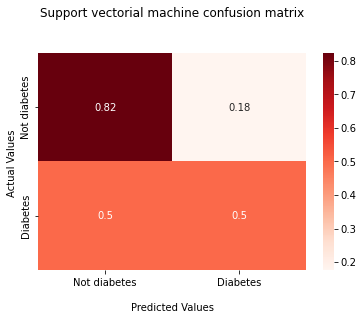

              precision    recall  f1-score   support

Not diabetes       0.74      0.82      0.78        74
    Diabetes       0.62      0.50      0.55        42

    accuracy                           0.71       116
   macro avg       0.68      0.66      0.67       116
weighted avg       0.70      0.71      0.70       116



In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = svm.SVC(kernel='rbf',C=100) #SVM model
model.fit(x_train, y_train)#Fit the model according to the given training dataset
y_pred = model.predict(x_test) #Predictt values for test data

cf_matrix = confusion_matrix(y_test, y_pred,normalize='true'); #Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
metrics_results['SVM']=[recall_score(y_test,y_pred),specificity(tn,fp)];#Recall and specificity
cf_results['SVM']=classification_report(y_test, y_pred, target_names=['0','1']);#Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds');#confusion matrix heatmap

ax.set_title('Support vectorial machine confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not diabetes','Diabetes'])
ax.yaxis.set_ticklabels(['Not diabetes','Diabetes'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test, y_pred, target_names=['Not diabetes','Diabetes'])) #Classification report

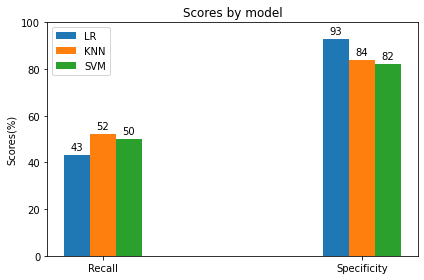

In [30]:
labels = ['Recall', 'Specificity']
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
#Bar plots
rects1 = ax.bar(x - width, np.round(metrics_results['LR'],2)*100, width, label='LR')
rects2 = ax.bar(x , np.round(metrics_results['KNN'],2)*100, width, label='KNN')
rects3 = ax.bar(x + width, np.round(metrics_results['SVM'],2)*100, width, label='SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores(%)')
ax.set_title('Scores by model')
ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim(0,100)#Y axis limit

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
plt.show()

The model that presents the best results is LR, both for the positive cases and slightly for the negative ones, however, when it comes to a health problem, these results are still poor, therefore, neural network models will be created to try to give a better solution to the prediction problem.

NEURAL NETWORKS USING PYTORCH

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [32]:
#Device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using: {device}')

Using: cpu


In [33]:
#Numpy to tensor to device
x_train_tensor = torch.FloatTensor(x_train).to(device)
x_test_tensor = torch.FloatTensor(x_test).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [34]:
torch.cuda.empty_cache() #Releases all idle cache currently held by the cache allocator so it can be used by other GPU applications and visible in nvidia-smi

In [35]:
#Data shape
print(x_train_tensor.shape,y_train_tensor.shape)
print(x_test_tensor.shape,y_test_tensor.shape)

torch.Size([652, 8]) torch.Size([652])
torch.Size([116, 8]) torch.Size([116])


4.ARTIFICIAL NEURAL NETWORK MODEL 1: Training without mini bacthes

In [36]:
### Creating Model from Scratch.
### ANN_Model inherits functionalities of nn.Module, nn is a library.
### There are 2 output features.

class ANN_Model1(nn.Module):
    def __init__(self, input_features = 8 , out_features = 2): #Initialization, Constructor inside class ANN_Model
        super(ANN_Model1,self).__init__()    #Inherits the nn.Module
        # Network architecture
        self.fully_connected_layer1 = nn.Linear(input_features, 120)     #Same as dense class in keras.
        self.fully_connected_layer2 = nn.Linear(120, 300)
        self.fully_connected_layer3 = nn.Linear(300,600)
        self.fully_connected_layer4 = nn.Linear(600,200)
        self.fully_connected_layer5 = nn.Linear(200,100)
        self.output_layer = nn.Linear(100, out_features)
    def forward(self,x):          #Forward Propagation function inside class ANN_Model
        x = F.relu(self.fully_connected_layer1(x))
        x = F.leaky_relu(self.fully_connected_layer2(x))
        x = F.leaky_relu(self.fully_connected_layer3(x))
        x = F.leaky_relu(self.fully_connected_layer4(x))
        x = F.leaky_relu(self.fully_connected_layer5(x))
        x = (self.output_layer(x))
        return(x)

In [37]:
torch.manual_seed(20) #Set seed
model = ANN_Model1()

In [38]:
def train_loop(model,x_train,y_train,epochs,optimizer,loss_function):
    model=model.to(device)
    losses_values=[] #List to store losses values for epoch
    model.train() #Model in train mode

    for i in range(epochs): #Iterating over epoch
        i+=1;
        y_pred=model.forward(x_train) #Forward propagation
        loss=loss_function(y_pred,y_train) # Compute loss
        losses_values.append(loss.item()) #Add loss value to list
        if (i+1)%100 == 1: #Every 10 epoch display result 
            print("Epoch number : {} and the loss : {}".format(i,loss))
        #Due to pytorch accumulates gradients they are set to zero
        optimizer.zero_grad()
        #Backpropagation
        loss.backward()
        #Single optimization step
        optimizer.step()
        #for name, param in model.named_parameters():
        #    print(name, param.grad.abs().sum())
    return epochs,losses_values #Return epoch list and values

In [39]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Implements adam algorithm
num_epochs=500;#Num of epochs
epoch,final_losses=train_loop(model,x_train_tensor,y_train_tensor,num_epochs,optimizer,loss_function) #Train the model

Epoch number : 100 and the loss : 0.3117353618144989
Epoch number : 200 and the loss : 0.6479015946388245
Epoch number : 300 and the loss : 0.3046339154243469
Epoch number : 400 and the loss : 0.05679379776120186
Epoch number : 500 and the loss : 0.3052648603916168


Text(0, 0.5, 'Loss')

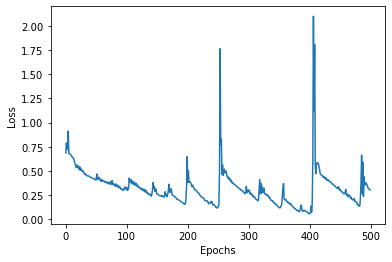

In [40]:
#Losses for each epoch
plt.plot(range(epoch), final_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [41]:
def prediction_loop(model,x_test_tensor):
    #Prediction values function
    predictions = [] #List to store predictions 
    model.eval() #Model evaluation mode
    with torch.no_grad(): #Dissable gradient calculation
        for i, data in enumerate(x_test_tensor):
            y_pred = model.forward(data) #Forward
            predictions.append(y_pred.argmax().item()) #Which index is maximum using .argmax(); 0 or 1.
    return predictions

In [42]:
predictions=prediction_loop(model,x_test_tensor) #Predictions given model and features test data

In [43]:
y_test_tensor = y_test_tensor.cpu().detach().numpy() #Tensor to numpy

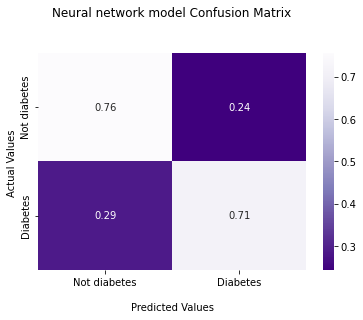

              precision    recall  f1-score   support

Not diabetes       0.82      0.76      0.79        74
    Diabetes       0.62      0.71      0.67        42

    accuracy                           0.74       116
   macro avg       0.72      0.74      0.73       116
weighted avg       0.75      0.74      0.74       116



In [44]:
cf_matrix = confusion_matrix(y_test_tensor, predictions,normalize='true') #Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
metrics_results['NN1']=[recall_score(y_test_tensor,predictions),specificity(tn,fp)];#Recall and specificity
cf_results['NN1']=classification_report(y_test_tensor,predictions, target_names=['Not diabetes','Diabetes']); #Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples_r') ;#confusion matrix heatmap

ax.set_title('Neural network model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not diabetes','Diabetes'])
ax.yaxis.set_ticklabels(['Not diabetes','Diabetes'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cf_results['NN1']) #Classification report

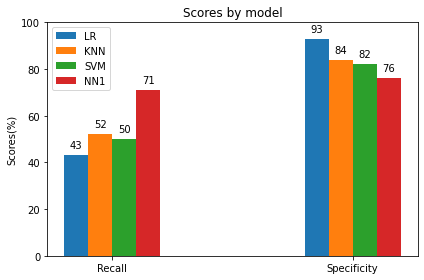

In [45]:
labels = ['Recall', 'Specificity']
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, np.round(metrics_results['LR'],2)*100, width, label='LR')
rects2 = ax.bar(x , np.round(metrics_results['KNN'],2)*100, width, label='KNN')
rects3 = ax.bar(x + width, np.round(metrics_results['SVM'],2)*100, width, label='SVM')
rects4 = ax.bar(x + 2*width, np.round(metrics_results['NN1'],2)*100, width, label='NN1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores(%)')
ax.set_title('Scores by model')
ax.set_xticks(x+width/2, labels)
ax.legend()
ax.set_ylim(0,100)

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)

fig.tight_layout()
plt.show()

5.ARTIFICIAL NEURAL NETWORK MODEL 2: Training with mini batches

In [46]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset): #Customized data
    def __init__(self,inputs,labels):
        # Initialize data, download, etc.
        assert inputs.shape[0] == labels.shape[0], 'Error number of samples'
        self.X=torch.FloatTensor(inputs).to(device)
        self.Y=torch.LongTensor(labels).to(device)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.X.shape[0]

In [47]:
Train_dataset=CustomDataset(x_train,y_train) #Train data into customdataset
Test_dataset=CustomDataset(x_test,y_test) #Test data into customdataset
mbsize=32 #Mini batch size

In [48]:
#Dataloader provide a iterable object and and generate the mini-batches
train_loader = DataLoader(dataset=Train_dataset,
                          batch_size=mbsize,
                          shuffle=True)
                          
test_loader = DataLoader(dataset=Test_dataset,
                          batch_size=mbsize,
                          shuffle=False)

In [49]:
### Creating Model from Scratch.
### ANN_Model inherits functionalities of nn.Module, nn is a library.
### There are 2 output features.

class ANN_Model2(nn.Module):
    def __init__(self, input_features = 8,out_features = 2): #Initialization, Constructor inside class ANN_Model
        super(ANN_Model2,self).__init__()    #Inherits the nn.Module
        self.fully_connected_layer1 = nn.Linear(input_features, 140)     #Same as dense class in keras.
        self.fully_connected_layer2 = nn.Linear(140, 300)
        self.fully_connected_layer3 = nn.Linear(300, 200)
        self.fully_connected_layer4 = nn.Linear(200,60)
        self.output_layer = nn.Linear(60, out_features)
    def forward(self,x):          #Forward Propagation function inside class ANN_Model
        x = F.relu(self.fully_connected_layer1(x))
        x = F.leaky_relu(self.fully_connected_layer2(x))
        x = F.leaky_relu(self.fully_connected_layer3(x))
        x = F.leaky_relu(self.fully_connected_layer4(x))
        x = (self.output_layer(x))
        return(x)

In [50]:
torch.cuda.empty_cache()

In [51]:
torch.manual_seed(20)
model = ANN_Model2()

In [56]:
def Train_loop(model,trainloader,num_epochs,optimizer,loss_function):
    losses=[] #List to store losses values
    loss=0;
    epochs=range(num_epochs)
    model.train() #Model train mode
    for epoch in range(num_epochs): #Iterating over num epoch
        for i,(xi,yi) in enumerate(trainloader): #Iterating over mini batch
            #Forward pass
            y_pred=model.forward(xi) 
            #print(y_pred,yi)
            #Loss
            loss=loss_function(y_pred,yi)
            #Backward propagation
            optimizer.zero_grad() #Reset gradients to zero to avoid accumulation
            loss.backward()
            optimizer.step()
        losses.append(loss.item())#Add loss value each epoch         
            
    return epochs,losses 

In [57]:
#Prediction values function
def prediction_loop(model,testdataset):
    predictions = [] #List to store predictions 
    labels=[] #List to store correct labels (diabetes or not)
    model.eval() #Evaluation mode
    with torch.no_grad(): #Dissable gradients calculations
        for i,(xi,yi) in enumerate(testdataset): #Iteration over values
            #Forward pass
            y_pred = model.forward(xi) 
            #print(y_pred)
            predictions.append(y_pred.argmax().item()) #Which index is maximum using .argmax(); 0 or 1.
            labels.append(yi)
    return labels,predictions

In [58]:
loss_function= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
num_epochs=1000
epoch,final_losses=Train_loop(model,train_loader,num_epochs,optimizer,loss_function)

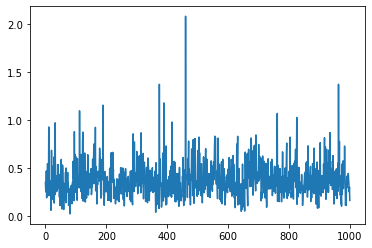

In [59]:
plt.plot(epoch,final_losses)

In [60]:
predictions=prediction_loop(model,Test_dataset)

In [61]:
cm=confusion_matrix(predictions[0],predictions[1]); #Confusion matrix given correct values and predictions 

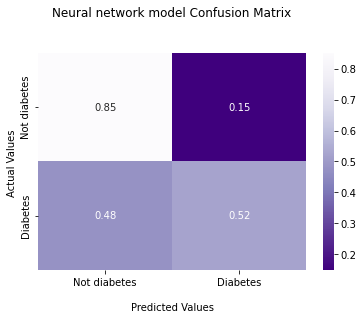

              precision    recall  f1-score   support

Not diabetes       0.76      0.85      0.80        74
    Diabetes       0.67      0.52      0.59        42

    accuracy                           0.73       116
   macro avg       0.71      0.69      0.69       116
weighted avg       0.73      0.73      0.72       116




In [62]:
cf_matrix = confusion_matrix(predictions[0], predictions[1],normalize='true')#Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
metrics_results['NN2']=[recall_score(predictions[0], predictions[1]),specificity(tn,fp)]; #Recall and specificity
cf_results['NN2']=classification_report(predictions[0], predictions[1],target_names=['Not diabetes','Diabetes']); #Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples_r') #confusion matrix heatmap

ax.set_title('Neural network model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not diabetes','Diabetes'])
ax.yaxis.set_ticklabels(['Not diabetes','Diabetes'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cf_results['NN2'])
print()

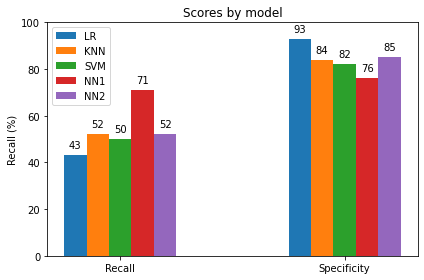

In [63]:
labels = ['Recall', 'Specificity']
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, np.round(metrics_results['LR'],2)*100, width, label='LR')
rects2 = ax.bar(x - width , np.round(metrics_results['KNN'],2)*100, width, label='KNN')
rects3 = ax.bar(x , np.round(metrics_results['SVM'],2)*100, width, label='SVM')
rects4 = ax.bar(x + width, np.round(metrics_results['NN1'],2)*100, width, label='NN1')
rects5= ax.bar(x + 2*width, np.round(metrics_results['NN2'],2)*100, width, label='NN2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall (%)')
ax.set_title('Scores by model')
ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim(0,100)

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)
ax.bar_label(rects5, padding=5)

fig.tight_layout()
plt.show()

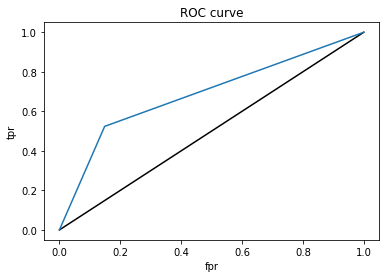

In [64]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(predictions[0], predictions[1])
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

The neural network-based models demonstrated significantly better performance than the other 3 models. Between these last two, the first architecture has a higher recall value and a little less specificity compared to the other network architecture. Bearing in mind that in the recall the models have presented lower performance with respect to specificity, the model that best solves the classification problem for the health problem presented is that of architecture number 1, input without mini lots.